In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as snb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
def draw_roc( actual, predicted ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, predicted,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, predicted )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [3]:
scaled_churn_data = pd.read_csv('traindata.csv')

In [4]:
#t = pd.read_csv('telecom_churn_data.csv')
scaled_churn_data['Unnamed: 0'].head()
scaled_churn_data = scaled_churn_data.drop(['Unnamed: 0'],axis = 1)

In [5]:
churn = scaled_churn_data['churn']
scaled_churn_data = scaled_churn_data.drop(['churn'],axis = 1)

In [6]:
#load test data
scaled_churn_data_test = pd.read_csv('testdata.csv')
churn_test = scaled_churn_data_test['churn']
scaled_churn_data_test = scaled_churn_data_test.drop(['churn'],axis = 1)

In [7]:
scaled_churn_data_test = scaled_churn_data_test.drop(['Unnamed: 0'],axis = 1)

In [8]:
scaled_churn_data_test.shape

(8710, 92)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(scaled_churn_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

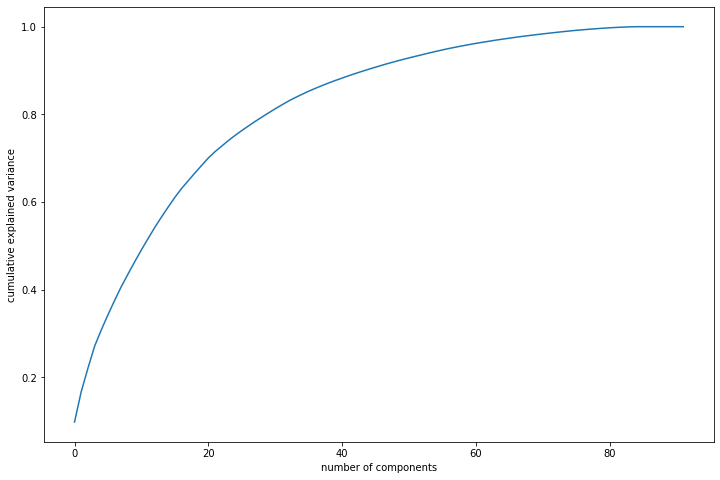

In [10]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [11]:
np.cumsum(pca.explained_variance_ratio_)

array([0.09838618, 0.16740066, 0.22079918, 0.27109559, 0.30837961,
       0.34285463, 0.37595014, 0.40734188, 0.43596058, 0.4640006 ,
       0.49099546, 0.51687521, 0.54225951, 0.56581505, 0.58867173,
       0.61075119, 0.63089856, 0.64867243, 0.66642053, 0.68360623,
       0.70051108, 0.71489059, 0.72760848, 0.74022213, 0.7520219 ,
       0.76301299, 0.77353228, 0.7839335 , 0.79369309, 0.80335742,
       0.81272438, 0.82173155, 0.83053093, 0.83834258, 0.84566504,
       0.85279727, 0.85939224, 0.86560531, 0.87172574, 0.87736893,
       0.88278113, 0.88814958, 0.89334096, 0.89824256, 0.90305048,
       0.90767112, 0.91221498, 0.91668393, 0.92084487, 0.92489459,
       0.92877229, 0.93253345, 0.93627213, 0.93995475, 0.94355104,
       0.94700803, 0.95034958, 0.9534122 , 0.95633781, 0.95919303,
       0.96192615, 0.96444992, 0.96690931, 0.96935704, 0.97162356,
       0.97383702, 0.97593115, 0.9779681 , 0.9799049 , 0.98174601,
       0.98357025, 0.98530431, 0.98698457, 0.98862659, 0.99019

In [12]:
#however we can take incremental PCA to get the values of data corresponding to new components
pca_final = IncrementalPCA(n_components=57)
churn_data_pca = pca_final.fit_transform(scaled_churn_data)
churn_data_pca.shape

(20322, 57)

In [13]:
churn_test_data = pca_final.transform(scaled_churn_data_test)

In [40]:
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
#hyperparameters = {'max_depth': [10,15,20,25,30,35,40,45,50],'min_samples_leaf':range(10,310,10),'n_estimators': range(50,750, 50),'max_features':range(10,45,5)}
hyperparameters = {'max_depth': [15,30,50],'min_samples_leaf':[30,150,300],'n_estimators': [50,140,80],'max_features':[5,25,50]}

In [41]:
rf = RandomForestClassifier( bootstrap=True,class_weight='balanced')
grid_search = GridSearchCV(estimator = rf, param_grid = hyperparameters, 
                          cv = 5, n_jobs = 30,verbose = 1,scoring = 'f1')
grid_search.fit(churn_data_pca,churn)
res = pd.DataFrame(grid_search.cv_results_)
res.to_csv('RandomForestGridSearchResult.csv')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed: 17.3min
[Parallel(n_jobs=30)]: Done 405 out of 405 | elapsed: 50.4min finished


In [43]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 30,max_features = 5,min_samples_leaf = 30,n_estimators = 140)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=30,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [46]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [47]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))

[[17296  1350]
 [  211  1465]]
0.9231866942230096


In [49]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))

[[7280  705]
 [ 251  474]]
0.8902411021814007


In [50]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 15,max_features = 25,min_samples_leaf = 30,n_estimators = 140)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features=25,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=30,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [51]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [52]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))

[[17237  1409]
 [  197  1479]]
0.9209723452416101


In [53]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))

[[7271  714]
 [ 243  482]]
0.890126291618829


In [66]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 15,max_features = 40,min_samples_leaf = 400,n_estimators = 80)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features=40,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=400,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [67]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [68]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))

[[14915  3731]
 [  340  1336]]
0.7996752288160615


In [69]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))

[[6264 1721]
 [ 161  564]]
0.7839265212399541


In [84]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 30,max_features = 50,min_samples_leaf = 330,n_estimators = 140)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=50,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=330,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=140, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [85]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [86]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))

[[14908  3738]
 [  340  1336]]
0.799330774530066


In [87]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))

[[6295 1690]
 [ 160  565]]
0.7876004592422503


In [ ]:
#Gid search with recall score

In [ ]:
folds = KFold(n_splits = 5,shuffle = True,random_state = 4)
#hyperparameters = {'max_depth': [10,15,20,25,30,35,40,45,50],'min_samples_leaf':range(10,310,10),'n_estimators': range(50,750, 50),'max_features':range(10,45,5)}
hyperparameters = {'max_depth': [15,30,50],'min_samples_leaf':[30,150,300],'n_estimators': [50,140,80],'max_features':[5,25,50]}

In [88]:
rf = RandomForestClassifier( bootstrap=True,class_weight='balanced')
grid_search = GridSearchCV(estimator = rf, param_grid = hyperparameters, 
                          cv = 5, n_jobs = 30,verbose = 1,scoring = 'recall',return_train_score = True)
grid_search.fit(churn_data_pca,churn)
res = pd.DataFrame(grid_search.cv_results_)
res.to_csv('RandomForestGridSearchResult_Recall.csv')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed: 22.0min
[Parallel(n_jobs=30)]: Done 405 out of 405 | elapsed: 56.6min finished


In [89]:
rfc = RandomForestClassifier( bootstrap=True,class_weight='balanced',max_depth = 50,max_features = 25,min_samples_leaf = 300,n_estimators = 80)
rfc.fit(churn_data_pca,churn)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=25,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=300,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [90]:
predict_train = rfc.predict(churn_data_pca)
predict_test = rfc.predict(churn_test_data)

In [91]:
print(metrics.confusion_matrix(churn,predict_train))
print(metrics.accuracy_score(churn,predict_train))

[[15404  3242]
 [  330  1346]]
0.8242298986320244


In [92]:
print(metrics.confusion_matrix(churn_test,predict_test))
print(metrics.accuracy_score(churn_test,predict_test))

[[6501 1484]
 [ 163  562]]
0.8109070034443169


In [ ]:
#Boosting Model

In [23]:
#from sklearn.tree import RandomForestClassifier
deep_tree = RandomForestClassifier(max_depth=50,min_samples_leaf = 300, random_state = 100,max_features =25 ,bootstrap=True,class_weight='balanced',n_estimators = 80)

In [24]:
#estimators = list(range(1, 80, 3))
from sklearn.ensemble import AdaBoostClassifier
estimators = [80,90,100]
abc_scores = []
recall_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=deep_tree, 
    n_estimators = n_est)
    
    ABC.fit(churn_data_pca, churn)
    y_pred = ABC.predict(churn_test_data)
    accuracy_score = metrics.accuracy_score(churn_test, y_pred)
    recall_score = metrics.recall_score(churn_test, y_pred)
    recall_scores.append(recall_score)
    abc_scores.append(accuracy_score)
#print(mean())

In [25]:
print(abc_scores)
print(recall_scores)

[0.9269804822043628, 0.9269804822043628, 0.9289322617680826]
[0.5144827586206897, 0.5089655172413793, 0.49517241379310345]
